# AP5 - Pattern Recognition
Train a Support Vector Machine (SVM) classifier to recognize 'Call', 'Open' and 'Close' voice commands.

> Name: Jonas Carvalho Fortes

> Mat: 494513

## Importing Libraries

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio, display
# install also ffmpeg in the system (https://ffmpeg.org/download.html) for extracting the signal from the audio files.
import ffmpeg

## Auxiliary Functions

In [273]:
def extract_audio_signal(file_path, start_sample=31380, end_sample=100000):
    """
    Extracts the audio signal from a file, crops it to a specified range, 
    and pads or truncates to ensure uniform length.
    
    Parameters:
        file_path (str): Path to the audio file.
        start_sample (int): The starting sample index for cropping the audio signal.
        end_sample (int): The ending sample index for cropping the audio signal.
        
    Returns:
        np.ndarray: A numpy array containing the cropped and padded audio signal.
    """
    try:
        # Use ffmpeg to extract the audio and convert it to wav format in memory
        out, _ = (
            ffmpeg
            .input(file_path)
            .output('pipe:', format='wav')
            .run(capture_stdout=True, capture_stderr=True)
        )

        # Convert the audio signal to a numpy array (assuming 16-bit PCM)
        signal = np.frombuffer(out, dtype=np.int16)
        
        # Crop the signal between the specified start and end samples
        signal_cropped = signal[start_sample:end_sample]

        # Check if the cropped signal is shorter than the desired end_sample length
        if len(signal_cropped) < (end_sample - start_sample):
            # Pad the signal with zeros if it is shorter
            signal_cropped = np.pad(signal_cropped, (0, (end_sample - start_sample) - len(signal_cropped)), 'constant')
        else:
            # Truncate the signal if it is longer
            signal_cropped = signal_cropped[:(end_sample - start_sample)]

        return signal_cropped

    except ffmpeg.Error as e:
        print(f"Error extracting audio signal from {file_path}: {e.stderr.decode()}")
        return None

In [274]:
def extract_audio_signal(file_path, start_sample=31380, end_sample=100000):
    """
    Extracts the audio signal from a file, crops it to a specified range, 
    and pads or truncates to ensure uniform length.
    
    Parameters:
        file_path (str): Path to the audio file.
        start_sample (int): The starting sample index for cropping the audio signal.
        end_sample (int): The ending sample index for cropping the audio signal.
        
    Returns:
        np.ndarray: A numpy array containing the cropped and padded audio signal.
    """
    try:
        # Use ffmpeg to extract the audio and convert it to wav format in memory
        out, _ = (
            ffmpeg
            .input(file_path)
            .output('pipe:', format='wav')
            .run(capture_stdout=True, capture_stderr=True)
        )

        # Convert the audio signal to a numpy array (assuming 16-bit PCM)
        signal = np.frombuffer(out, dtype=np.int16)
        
        # Crop the signal between the specified start and end samples
        signal_cropped = signal[start_sample:end_sample]

        # Check if the cropped signal is shorter than the desired end_sample length
        if len(signal_cropped) < (end_sample - start_sample):
            # Pad the signal with zeros if it is shorter
            signal_cropped = np.pad(signal_cropped, (0, (end_sample - start_sample) - len(signal_cropped)), 'constant')
        else:
            # Truncate the signal if it is longer
            signal_cropped = signal_cropped[:(end_sample - start_sample)]

        return signal_cropped

    except ffmpeg.Error as e:
        print(f"Error extracting audio signal from {file_path}: {e.stderr.decode()}")
        return None

In [275]:
def create_audio_dataset(base_path, class_dirs):
    """
    Creates a dataset of audio signals extracted from files organized in class directories.
    
    Parameters:
        base_path (str): Path to the base directory containing class subdirectories.
        class_dirs (list): List of class subdirectories, where each subdirectory contains audio files.
        
    Returns:
        np.ndarray: A 2D numpy array where each row represents an audio signal.
        np.ndarray: A 1D numpy array containing the class labels for each audio signal.
    """
    dataset = []
    labels = []
    
    for label, class_dir in enumerate(class_dirs):
        class_path = os.path.join(base_path, class_dir)
        audio_files = sorted(os.listdir(class_path))  # Organize files to ensure consistent order
        print(f"Processing {len(audio_files)} files in {class_dir}...")
        for audio_file in audio_files:
            audio_path = os.path.join(class_path, audio_file)
            # Extract the audio signal using the extract_audio_signal function
            signal = extract_audio_signal(audio_path)
            
            if signal is not None:
                dataset.append(signal)
                labels.append(label)  # Add the corresponding class label
    
    # Convert lists to numpy arrays
    dataset = np.array(dataset)
    labels = np.array(labels)
    
    return dataset, labels

In [276]:
def save_audio_dataset_to_csv(signals, labels, output_file):
    """
    Saves the audio dataset and labels to a CSV file.
    
    Parameters:
        signals (np.ndarray): A 2D numpy array where each row represents an audio signal.
        labels (np.ndarray): A 1D numpy array containing the class labels for each audio signal.
        output_file (str): The path to the output CSV file.
    """
    # Create a pandas DataFrame from the dataset and labels
    df = pd.DataFrame(signals)
    
    # Add a column for the labels
    df['label'] = labels
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)

In [277]:
def get_audio_signal_from_dataset(df, index):
    """
    Retrieves an audio signal and its class label from a DataFrame containing an audio dataset.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the audio dataset.
        index (int): The index of the audio signal to retrieve.
        
    Returns:
        np.ndarray: The audio signal as a numpy array.
        label (int): The class label for the audio signal.
    """
    signal = df.iloc[index, :-1].values
    label = df.iloc[index, -1]
    return signal, label

In [278]:
def plot_audio_signal(signal, title="Audio Signal"):
    """
    Plots the audio signal as a waveform.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()


In [279]:
def play_audio_signal(signal, sample_rate=44100*2.1):
    """
    Plays an audio signal using IPython's Audio display.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        sample_rate (int): The sample rate of the audio signal in Hz. Default is 95900.
    """
    # Normalize the signal to the range [-1, 1] if it's in 16-bit PCM format
    if signal.dtype == np.int16:
        signal = signal / np.iinfo(np.int16).max  # Normalize to the range [-1, 1]
    
    # Display the audio player with the normalized signal
    display(Audio(signal, rate=sample_rate))

## Data preparation

In [280]:
base_path = './data/audios'  # base path for the audio files
class_dirs = ['abrir', 'fechar', 'ligar']  # class subdirectories

# Create the audio dataset
signals, labels = create_audio_dataset(base_path, class_dirs)

print(f"Dataset shape: {signals.shape}")  # Should be (45, length_signal)
print(f"Labels shape: {labels.shape}")    # Deve ser (45,)

Processing 15 files in abrir...
Processing 15 files in fechar...
Processing 15 files in ligar...
Dataset shape: (45, 68620)
Labels shape: (45,)


In [281]:
output_file = "data/audio_signals_dataset.csv"

# Save the audio dataset to a CSV file
save_audio_dataset_to_csv(signals, labels, output_file)

print(f"Dataset saved to {output_file}")

Dataset saved to data/audio_signals_dataset.csv


## Feature extraction

### Load Dataset

In [282]:
# Path to the CSV file containing the audio dataset
file_path = "data/audio_signals_dataset.csv"

# Read the dataset from the CSV file
df = pd.read_csv(file_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,68611,68612,68613,68614,68615,68616,68617,68618,68619,label
0,43,239,41,228,26,225,57,228,70,231,...,-737,867,-701,977,-699,973,-713,923,-663,0
1,78,225,85,230,122,241,101,237,91,241,...,-577,287,-559,256,-542,247,-529,306,-523,0
2,98,208,115,212,97,214,95,211,101,217,...,-439,1423,-485,1547,-536,1643,-558,1786,-578,0
3,-11,172,11,174,24,183,37,190,80,193,...,-4866,-4673,-4823,-4700,-4833,-4799,-4742,-4548,-4517,0
4,15,222,36,221,48,239,107,242,139,242,...,-660,-490,-662,-474,-684,-411,-720,-361,-746,0


### Plotting the audio signals

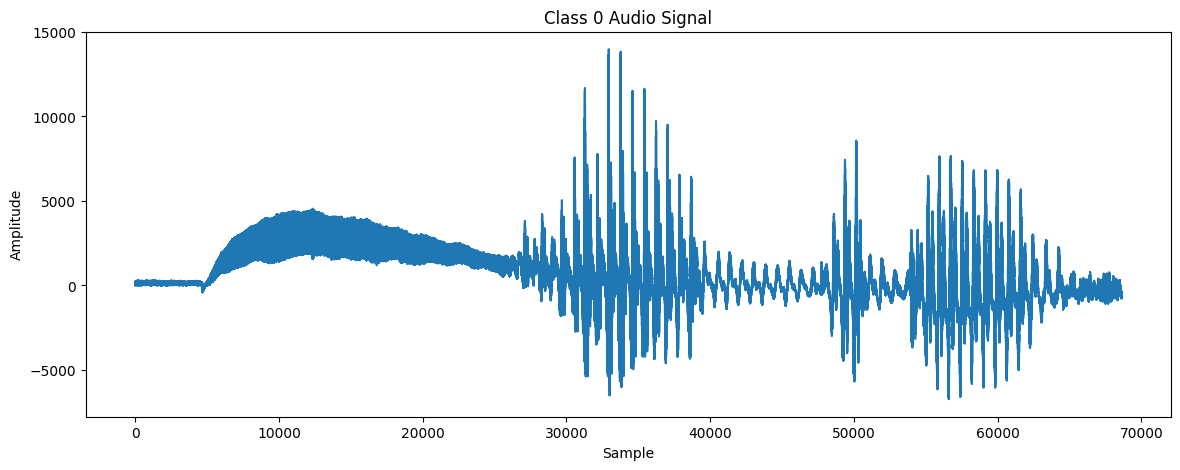

In [284]:
# Plot a sample audio signal from the dataset - class 0

audio_index = 4 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plotar o sinal de áudio
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

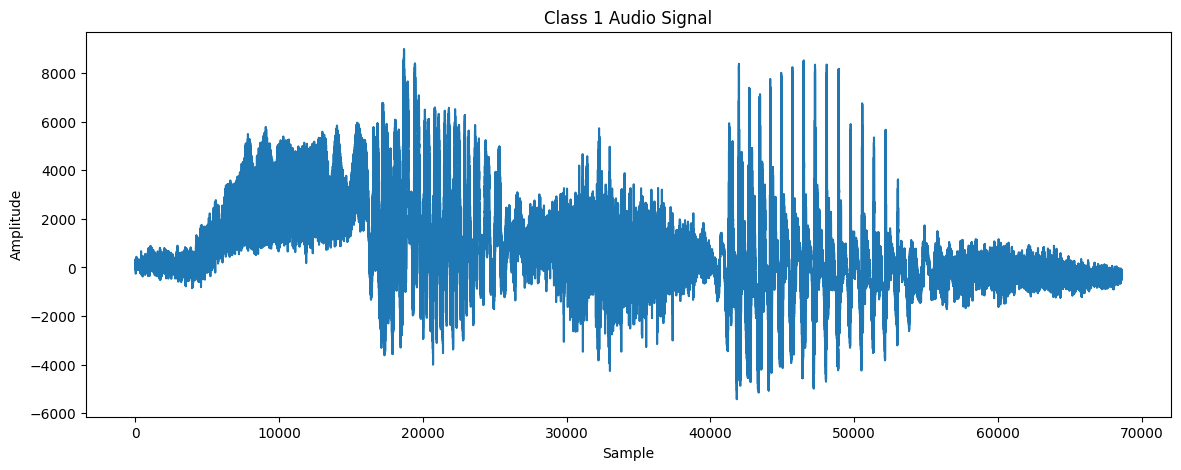

In [285]:
# Plot a sample audio signal from the dataset - class 1

audio_index = 15 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plotar o sinal de áudio
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

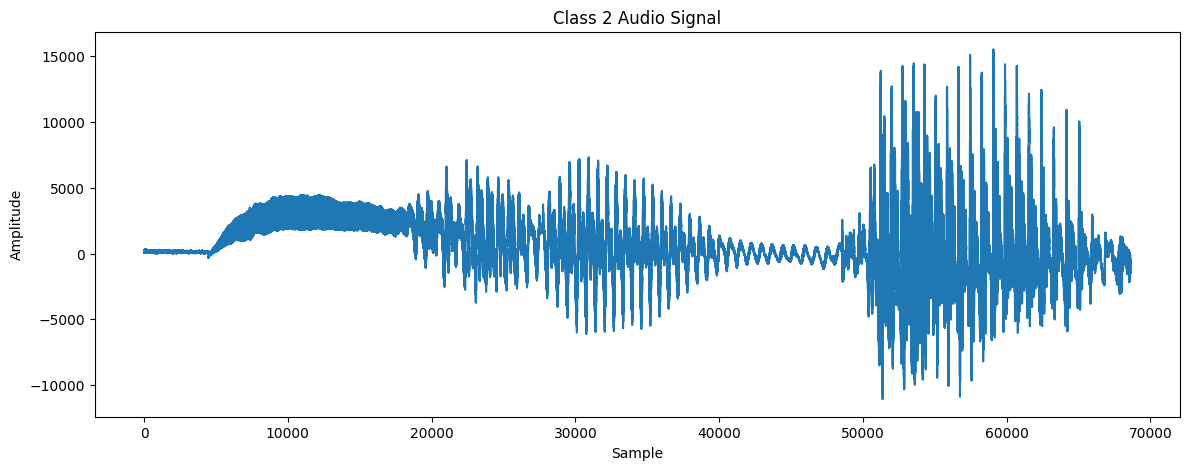

In [286]:
# Plot a sample audio signal from the dataset - class 2

audio_index = 30 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plotar o sinal de áudio
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

## Features definitions

#soon